In [ ]:
#!git clone https://github.com/CW-Huang/IFT6135H20_assignment.git

In [ ]:
import sys
sys.path.insert(0,'./IFT6135H20_assignment/assignment3/')

In [ ]:
import torch
import pdb
from tqdm.notebook import tqdm
from q3_sampler import svhn_sampler
from q3_model import Critic, Generator
from q2_solution import vf_wasserstein_distance
from torch import optim
from torch.autograd import Variable
import numpy as np
from copy import deepcopy

In [ ]:
# Example of usage of the code provided and recommended hyper parameters for training GANs.
data_root = './'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_iter = 50000 # N training iterations
n_critic_updates = 5 # N critic updates per generator update
lp_coeff = 10 # Lipschitz penalty coefficient
train_batch_size = 256
test_batch_size = 256
lr = 1e-4
beta1 = 0.5
beta2 = 0.9
z_dim = 100

train_loader, valid_loader, test_loader = svhn_sampler(data_root, train_batch_size, test_batch_size)

generator = Generator(z_dim=z_dim).to(device)
critic = Critic().to(device)

optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))
optim_generator = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# COMPLETE TRAINING PROCEDURE

# COMPLETE QUALITATIVE EVALUATION


Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [ ]:
%reload_ext autoreload
%autoreload 1

In [ ]:
def lp_reg(x, y, critic):

    sample = torch.rand(x.shape,dtype=x.dtype).requires_grad_().to(device)
    x_hat = sample*x + (1-sample)*y
    f_hat = critic(x_hat)
    f_grad = torch.autograd.grad(f_hat, x_hat, grad_outputs=torch.ones_like(f_hat), 
                                    retain_graph=True, create_graph= True )
    f_norm = (f_grad[0]**2).sum(-1).sqrt()
    zs = torch.zeros_like(f_norm)

    return  ((torch.max(zs,f_norm-1))**2).mean()

In [ ]:
n_epochs = 100
for epoch in tqdm(range(n_epochs)):
  print_i = np.random.randint(0,500,2)
  for i,(imgs,_) in enumerate(train_loader):
    real_imgs = imgs.to(device)

    optim_critic.zero_grad()

    # Sample noise as generator input
    #z = Variable(torch.as_tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))
    z = torch.empty(imgs.shape[0], z_dim).normal_().requires_grad_().to(device)
    # Generate a batch of images
    fake_imgs = generator(z).detach()

    loss_D = vf_wasserstein_distance(fake_imgs, real_imgs, critic) + lp_coeff * lp_reg(fake_imgs, real_imgs, critic)

    loss_D.backward()
    optim_critic.step()

    # Train the generator every n_critic iterations
    if i % n_critic_updates == 0:
      optim_generator.zero_grad()

      # Generate a batch of images
      gen_imgs = generator(z)
      # Adversarial loss
      loss_G = -torch.mean(critic(gen_imgs))

      loss_G.backward()
      optim_generator.step()

    if i in print_i:
        print(
            "[Epoch %d/%d] [Batch %d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, loss_D.item(), loss_G.item())
        )

In [ ]:
torch.save(generator, 'generator.pt')
torch.save(critic, 'critic.pt')

In [ ]:
generator = torch.load('generator.pt')
critic = torch.load('critic.pt')

Problem 3.1


In [ ]:
import matplotlib.pyplot as plt
denorm  = lambda x: x*0.5+0.5

In [ ]:
def plot_images(img_tensor,save=False,name='default'):
    _,axs = plt.subplots(8,8,figsize=(10,10))
    img_tensor = denorm(img_tensor.cpu())
    for i,ax in enumerate(axs.flatten()):
        img = img_tensor[i].permute(1,2,0).detach().numpy()
        ax.imshow(img)
        ax.axis('off')
    if save: plt.savefig(name)
    plt.show()

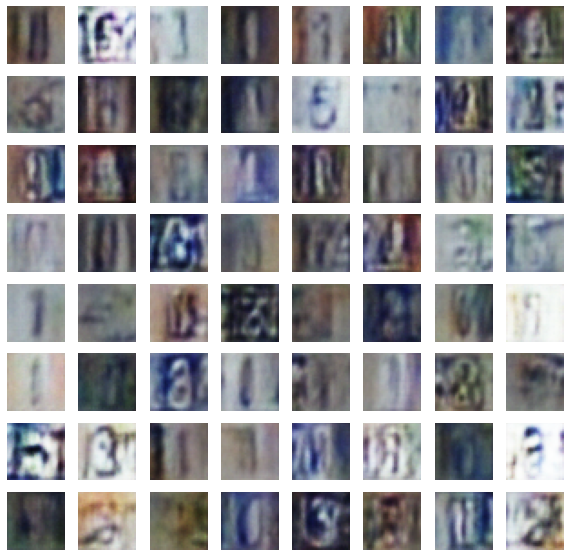

In [ ]:
z = torch.randn(100, 100).to(device)
image_tensors = generator(z)
plot_images(image_tensors,True)

Problem 3.2

[-10.0, -9.8, -9.600000000000001, -9.4, -9.200000000000001, -9.0, -8.8, -8.6, -8.4, -8.200000000000001, -8.0, -7.800000000000001, -7.6000000000000005, -7.4, -7.2, -7.0, -6.800000000000001, -6.6000000000000005, -6.4, -6.2, -6.0, -5.800000000000001, -5.6000000000000005, -5.4, -5.2, -5.0, -4.800000000000001, -4.6000000000000005, -4.4, -4.2, -4.0, -3.8000000000000003, -3.6, -3.4000000000000004, -3.2, -3.0, -2.8000000000000003, -2.6, -2.4000000000000004, -2.2, -2.0, -1.8, -1.6, -1.4000000000000001, -1.2000000000000002, -1.0, -0.8, -0.6000000000000001, -0.4, -0.2, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8000000000000003, 3.0, 3.2, 3.4000000000000004, 3.6, 3.8000000000000003, 4.0, 4.2, 4.4, 4.6000000000000005, 4.800000000000001, 5.0, 5.2, 5.4, 5.6000000000000005, 5.800000000000001, 6.0, 6.2, 6.4, 6.6000000000000005, 6.800000000000001, 7.0, 7.2, 7.4, 7.6000000000000005, 7.800000000000001, 8.0, 8.200000000000

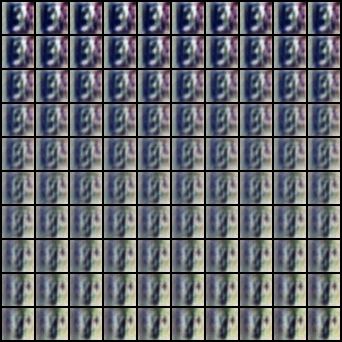

In [ ]:
def discover_disentanglement(idx, change, num=100):
  z = torch.randn(100).to(device)
  Z = torch.randn(num,100).to(device)
  sub = [-change*i for i in range(1,num//2+1)][::-1]
  add = [change*i for i in range(1,num//2+1)]
  print(sub+add)
  for i, ch in enumerate(sub+add):
    Z[i] = deepcopy(z)
    Z[i][idx] += ch 
  return Z

tensors = discover_disentanglement(1,0.2)

image_tensors = generator(tensors)
torchvision.utils.save_image(image_tensors, 'temp3.png', nrow=10, normalize=True)
image_grid_of_images = Image('temp3.png')
display(image_grid_of_images)

Problem 3.3

In [ ]:
def plot_line(img_tensor,save=False,name='default'):
    _,axs = plt.subplots(1,11,figsize=(10,5))
    img_tensor = denorm(img_tensor.cpu())
    for i,ax in enumerate(axs.flatten()):
        img = img_tensor[i].permute(1,2,0).detach().numpy()
        ax.imshow(img)
        ax.axis('off')
    if save: plt.savefig(name)
    plt.show()

In [ ]:
z0 = torch.randn(100).to(device)
z1 = torch.randn(100).to(device)
alpha = torch.arange(0,1.1,0.1).to(device)
print(alpha)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], device='cuda:0')


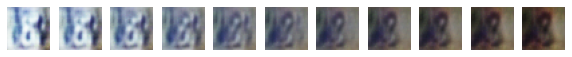

In [ ]:
alpha = alpha.view(-1,1)
z_dash_a = alpha*z0 + (1-alpha)*z1
image_tensors = generator(z_dash_a)
plot_line(image_tensors,True,'line1')

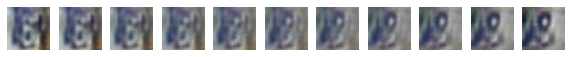

In [ ]:
image_tensors_1 = generator(z0.view(1,-1))
image_tensors_2 = generator(z1.view(1,-1))
alpha = alpha.view(-1,1,1,1)
image_tensors = alpha*image_tensors_1 + (1-alpha)*image_tensors_2
plot_line(image_tensors,True,'line2')